# DL HW1
## David Kiskovski

## Intro  

In [146]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import keras.utils
from keras import utils as np_utils
from keras.layers import UpSampling2D
from keras.layers import Dropout
import numpy as np
import matplotlib.patches as patches
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.models import Sequential

In [147]:
#Fit size of image we want
IMAGE_SIZE = 72

In [148]:
def m_drawing(figsize, U, V, noise=0.0):
    fg = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fg.canvas.draw()
    idta = np.frombuffer(fg.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    idta = idta + noise * np.random.random(idta.size)
    plt.close(fg)
    return idta

In [149]:
def m_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return m_drawing(figsize, U, V, noise)

In [150]:
def m_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    idta = m_drawing(figsize, U, V, noise)
    return [idta, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [151]:
def m_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return m_drawing(figsize, U, V, noise)

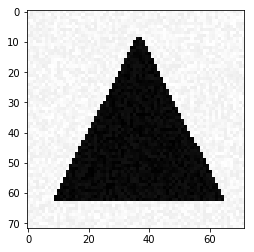

In [152]:
[sh, h] = m_triangle(20, False)
plt.imshow(sh.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

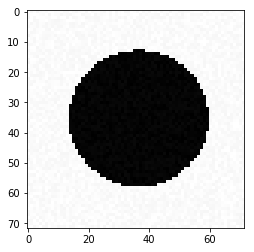

In [153]:
sh = m_disk(10)
plt.imshow(sh.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

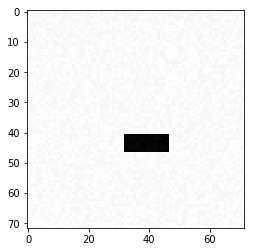

In [154]:
sh = m_rectangle(10, True)
plt.imshow(sh.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [155]:
def m_dta_class(smpls, noise=0.0, free_location=False):
    i_size = m_rectangle().shape[0]
    X = np.zeros([smpls,i_size])
    Y = np.zeros(smpls)
    print('Creating data:')
    for i in range(smpls):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = m_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = m_disk(noise, free_location)
        else:
            [X[i], V] = m_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [156]:
def m_test_regr():
    np.random.seed(42)
    [X_test, Y_test] = m_dta_regr(300, 20)
    return [X_test, Y_test]

In [157]:
def m_test_class():
    np.random.seed(50)
    [X_test, Y_test] = m_dta_class(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [158]:
def m_dta_regr(smpls, noise=0.0):
    i_size = m_triangle()[0].shape[0]
    X = np.zeros([smpls,i_size])
    Y = np.zeros([smpls, 6])
    print('Creating data:')
    for i in range(smpls):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = m_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [159]:
def visu_pred(x, y):
    fg, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

Set of images of shapes:

In [162]:
[X_train, Y_train] = m_dta_class(350, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


In [163]:
Y_train = keras.utils.to_categorical(Y_train, 3)

## Linear classifier for three categories of images

### Adam:

In [164]:
class1 = Sequential()
class1.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax", input_shape=(X_train.shape[1],)))

In [165]:
from keras import optimizers

In [166]:
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
class1.compile(loss='categorical_crossentropy',optimizer='adam')

In [168]:
class1.fit(X_train, Y_train, epochs=150, batch_size=64)

Epoch 1/150
350/350 [==============================] - 0s 195us/step - loss: 0.0019
Epoch 2/150
350/350 [==============================] - 0s 156us/step - loss: 0.0019
Epoch 3/150
350/350 [==============================] - 0s 148us/step - loss: 0.0019
Epoch 4/150
350/350 [==============================] - 0s 156us/step - loss: 0.0019
Epoch 5/150
350/350 [==============================] - 0s 257us/step - loss: 0.0018
Epoch 6/150
350/350 [==============================] - 0s 158us/step - loss: 0.0018
Epoch 7/150
350/350 [==============================] - 0s 151us/step - loss: 0.0018
Epoch 8/150
350/350 [==============================] - 0s 146us/step - loss: 0.0018
Epoch 9/150
350/350 [==============================] - 0s 183us/step - loss: 0.0018
Epoch 10/150
350/350 [==============================] - 0s 184us/step - loss: 0.0018
Epoch 11/150
350/350 [==============================] - 0s 169us/step - loss: 0.0018
Epoch 12/150
350/350 [==============================] - 0s 195us/step - lo

350/350 [==============================] - 0s 165us/step - loss: 0.0012
Epoch 98/150
350/350 [==============================] - 0s 160us/step - loss: 0.0012
Epoch 99/150
350/350 [==============================] - 0s 161us/step - loss: 0.0012
Epoch 100/150
350/350 [==============================] - 0s 169us/step - loss: 0.0012
Epoch 101/150
350/350 [==============================] - 0s 217us/step - loss: 0.0012
Epoch 102/150
350/350 [==============================] - 0s 215us/step - loss: 0.0012
Epoch 103/150
350/350 [==============================] - 0s 207us/step - loss: 0.0012
Epoch 104/150
350/350 [==============================] - 0s 247us/step - loss: 0.0012
Epoch 105/150
350/350 [==============================] - 0s 181us/step - loss: 0.0011
Epoch 106/150
350/350 [==============================] - 0s 185us/step - loss: 0.0011
Epoch 107/150
350/350 [==============================] - 0s 193us/step - loss: 0.0011
Epoch 108/150
350/350 [==============================] - 0s 148us/step

In [169]:
X_test = m_disk()
X_test = X_test.reshape(1, X_test.shape[0])
class1.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

### Stochastic Gradient Descent :

In [170]:
class2 = Sequential()
class2.add(Dense(units=64,kernel_initializer= 'uniform',activation="relu", input_shape=(X_train.shape[1],)))
class2.add(Dropout(rate=0.2))
class2.add(Dense(units=20,kernel_initializer= 'uniform',activation="relu"))
class2.add(Dropout(rate=0.2))
class2.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax"))

In [171]:
# Compile initialized gradient optimizer with model:

In [172]:
dsct = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
class2.compile(loss='categorical_crossentropy',optimizer=dsct, metrics=["accuracy"])

In [179]:
class2.fit(X_train, Y_train, epochs=150, batch_size=64)

Epoch 1/150
350/350 [==============================] - 0s 314us/step - loss: 0.4806 - acc: 0.6800
Epoch 2/150
350/350 [==============================] - 0s 280us/step - loss: 0.5368 - acc: 0.6543
Epoch 3/150
350/350 [==============================] - 0s 270us/step - loss: 0.5347 - acc: 0.6829
Epoch 4/150
350/350 [==============================] - 0s 317us/step - loss: 0.5268 - acc: 0.6829
Epoch 5/150
350/350 [==============================] - 0s 237us/step - loss: 0.4987 - acc: 0.6714
Epoch 6/150
350/350 [==============================] - 0s 316us/step - loss: 0.4730 - acc: 0.6800
Epoch 7/150
350/350 [==============================] - 0s 300us/step - loss: 0.4951 - acc: 0.6914
Epoch 8/150
350/350 [==============================] - 0s 283us/step - loss: 0.5137 - acc: 0.6571
Epoch 9/150
350/350 [==============================] - 0s 308us/step - loss: 0.5804 - acc: 0.6514
Epoch 10/150
350/350 [==============================] - 0s 308us/step - loss: 0.5661 - acc: 0.6600
Epoch 11/150
350/35

350/350 [==============================] - 0s 324us/step - loss: 0.5080 - acc: 0.6771
Epoch 84/150
350/350 [==============================] - 0s 352us/step - loss: 0.5875 - acc: 0.6571
Epoch 85/150
350/350 [==============================] - 0s 310us/step - loss: 0.5139 - acc: 0.6743
Epoch 86/150
350/350 [==============================] - 0s 346us/step - loss: 0.5294 - acc: 0.6714
Epoch 87/150
350/350 [==============================] - 0s 346us/step - loss: 0.5090 - acc: 0.6771
Epoch 88/150
350/350 [==============================] - 0s 311us/step - loss: 0.5114 - acc: 0.6771
Epoch 89/150
350/350 [==============================] - 0s 353us/step - loss: 0.5182 - acc: 0.6743
Epoch 90/150
350/350 [==============================] - 0s 335us/step - loss: 0.5486 - acc: 0.6657
Epoch 91/150
350/350 [==============================] - 0s 340us/step - loss: 0.4870 - acc: 0.6800
Epoch 92/150
350/350 [==============================] - 0s 346us/step - loss: 0.5169 - acc: 0.6743
Epoch 93/150
350/350 [=

In [180]:
X_test = m_disk()
X_test = X_test.reshape(1, X_test.shape[0])
class2.predict(X_test)

array([[0.46838132, 0.50900644, 0.02261222]], dtype=float32)

In [181]:
[X_test, Y_test] = m_dta_class(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [182]:
Y_test=keras.utils.to_categorical(Y_test, 3)

In [183]:
class2.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 2ms/step


[0.48339714924494426, 0.683333334128062]

## Visualization 

###  Stochastic Gradient Descent:

In [184]:
class2.get_weights()

[array([[ 0.02857787, -0.00924891, -0.0566795 , ...,  0.04925467,
         -0.01231375,  0.00396256],
        [-0.03031432, -0.02117886, -0.01057098, ...,  0.00649414,
          0.02985455, -0.05607876],
        [-0.04031097,  0.03135011, -0.03942272, ...,  0.04953474,
          0.02900839,  0.04158708],
        ...,
        [ 0.02330506,  0.03267567, -0.04176903, ...,  0.0090082 ,
         -0.05477479, -0.01593697],
        [ 0.02847643, -0.04635125,  0.00830125, ...,  0.00431921,
         -0.06266011,  0.0153923 ],
        [-0.04925165, -0.03987079,  0.00535977, ...,  0.03463411,
         -0.01324886, -0.05712413]], dtype=float32),
 array([-7.95846514e-04, -3.26224486e-03, -1.42960306e-02, -1.25850383e-02,
         0.00000000e+00,  0.00000000e+00, -1.23889325e-02, -2.65585445e-03,
        -4.43038851e-04, -9.33059957e-03, -9.95177031e-03, -4.67493781e-04,
         0.00000000e+00, -1.72385611e-04, -1.36343325e-02, -6.74486160e-03,
        -3.37114162e-03, -5.36163461e-05, -3.29734350e

In [185]:
A1=class2.get_weights()[0]

In [186]:
i1=A1[:,0]
i2=A1[:,1]
i3=A1[:,2]

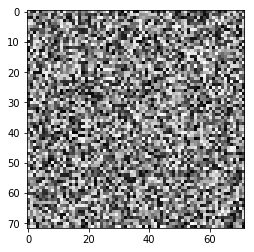

In [187]:
plt.imshow(i1.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest', cmap='gray')

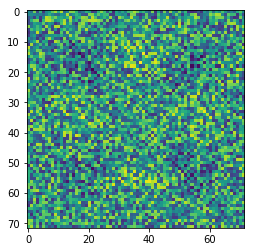

In [188]:
plt.imshow(i2.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest')

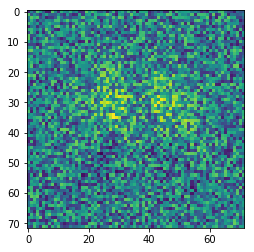

In [189]:
plt.imshow(i3.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest')

### Adam:

In [190]:
class1.get_weights()

[array([[ 0.04711089,  0.01469843,  0.01227014],
        [ 0.01006752, -0.04775855,  0.03592027],
        [ 0.02976719, -0.03157744,  0.01660763],
        ...,
        [ 0.044949  ,  0.04391314, -0.00193161],
        [ 0.00277864,  0.01649582,  0.00225872],
        [ 0.03555985, -0.00515882, -0.03088137]], dtype=float32),
 array([ 0.00192975, -0.0005239 , -0.00190714], dtype=float32)]

In [191]:
A2=class1.get_weights()[0]

In [192]:
i4=A2[:,0]
i5=A2[:,1]
i6=A2[:,2]

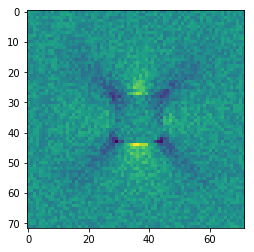

In [193]:
plt.imshow(i4.reshape(IMAGE_SIZE, IMAGE_SIZE))

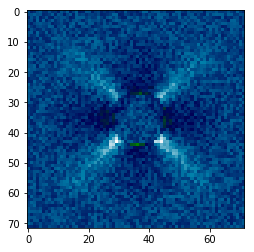

In [194]:
plt.imshow(i5.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest', cmap='ocean')

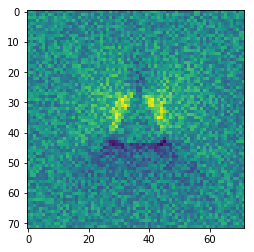

In [195]:
plt.imshow(i6.reshape(IMAGE_SIZE, IMAGE_SIZE), interpolation='nearest')

### Classicification2

In [196]:
[X_train2, Y_train2] = m_dta_class(350, 20, True)
Y_trainc2 = keras.utils.to_categorical(Y_train2, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


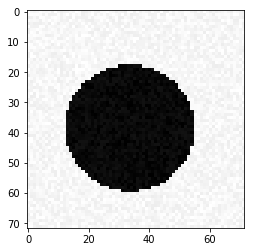

In [202]:
plt.imshow(X_train2[200].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [198]:
class3 = Sequential()
class3.add(Dense(units=20,kernel_initializer= 'uniform',activation="relu", input_shape=(X_train.shape[1],)))
class3.add(Dropout(rate=0.2))
class3.add(Dense(units=9,kernel_initializer= 'uniform',activation="relu"))
class3.add(Dropout(rate=0.2))
class3.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax"))



In [199]:
dsct = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
class3.compile(loss='categorical_crossentropy',optimizer=dsct, metrics=["accuracy"])

In [200]:
class3.fit(X_train2, Y_trainc2, epochs=200, batch_size=32)

Epoch 1/200
350/350 [==============================] - 2s 5ms/step - loss: 1.0987 - acc: 0.3486
Epoch 2/200
350/350 [==============================] - 0s 238us/step - loss: 1.0967 - acc: 0.3771
Epoch 3/200
350/350 [==============================] - 0s 268us/step - loss: 1.0954 - acc: 0.3771
Epoch 4/200
350/350 [==============================] - 0s 331us/step - loss: 1.0934 - acc: 0.3771
Epoch 5/200
350/350 [==============================] - 0s 261us/step - loss: 1.0930 - acc: 0.3771
Epoch 6/200
350/350 [==============================] - 0s 264us/step - loss: 1.0938 - acc: 0.3771
Epoch 7/200
350/350 [==============================] - 0s 161us/step - loss: 1.0908 - acc: 0.3771
Epoch 8/200
350/350 [==============================] - 0s 285us/step - loss: 1.0891 - acc: 0.3857
Epoch 9/200
350/350 [==============================] - 0s 285us/step - loss: 1.0847 - acc: 0.4000
Epoch 10/200
350/350 [==============================] - 0s 220us/step - loss: 1.0738 - acc: 0.4171
Epoch 11/200
350/350 

350/350 [==============================] - 0s 241us/step - loss: 1.0931 - acc: 0.3771
Epoch 84/200
350/350 [==============================] - 0s 245us/step - loss: 1.0954 - acc: 0.3771
Epoch 85/200
350/350 [==============================] - 0s 334us/step - loss: 1.0945 - acc: 0.3771
Epoch 86/200
350/350 [==============================] - 0s 283us/step - loss: 1.0963 - acc: 0.3771
Epoch 87/200
350/350 [==============================] - 0s 288us/step - loss: 1.0950 - acc: 0.3771
Epoch 88/200
350/350 [==============================] - 0s 270us/step - loss: 1.0940 - acc: 0.3771
Epoch 89/200
350/350 [==============================] - 0s 295us/step - loss: 1.0948 - acc: 0.3771
Epoch 90/200
350/350 [==============================] - 0s 290us/step - loss: 1.0954 - acc: 0.3771
Epoch 91/200
350/350 [==============================] - 0s 264us/step - loss: 1.0931 - acc: 0.3771
Epoch 92/200
350/350 [==============================] - 0s 245us/step - loss: 1.0934 - acc: 0.3771
Epoch 93/200
350/350 [=

350/350 [==============================] - 0s 245us/step - loss: 1.0948 - acc: 0.3771
Epoch 165/200
350/350 [==============================] - 0s 237us/step - loss: 1.0948 - acc: 0.3771
Epoch 166/200
350/350 [==============================] - 0s 244us/step - loss: 1.0950 - acc: 0.3771
Epoch 167/200
350/350 [==============================] - 0s 303us/step - loss: 1.0943 - acc: 0.3771
Epoch 168/200
350/350 [==============================] - 0s 262us/step - loss: 1.0947 - acc: 0.3771 0s - loss: 1.0948 - acc: 0.378
Epoch 169/200
350/350 [==============================] - 0s 284us/step - loss: 1.0952 - acc: 0.3771
Epoch 170/200
350/350 [==============================] - 0s 266us/step - loss: 1.0944 - acc: 0.3771
Epoch 171/200
350/350 [==============================] - 0s 251us/step - loss: 1.0947 - acc: 0.3771
Epoch 172/200
350/350 [==============================] - 0s 242us/step - loss: 1.0946 - acc: 0.3771
Epoch 173/200
350/350 [==============================] - 0s 254us/step - loss: 1.09

In [203]:
[X_test2, Y_test2] = m_test_class()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [204]:
#Evaluate model 
class3.evaluate(X_test2, Y_test2)

300/300 [==============================] - 1s 2ms/step


[1.1016711044311522, 0.336666667064031]

In [205]:
#Reshape X_train 
X_train2 = X_train2.reshape(X_train2.shape[0],72,72,1)

In [206]:
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Flatten

In [207]:
#Convolutional model
class4 = Sequential()
class4.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(72,72,1)))
class4.add(MaxPooling2D(pool_size=(2, 2)))
class4.add(Flatten())
class4.add(Dense(70, activation='relu'))
class4.add(Dense(3, activation='sigmoid'))

In [208]:
# using cross entropy for classification problem 

In [209]:
class4.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=["accuracy"])

In [210]:
class4.fit(X_train2, Y_trainc2, batch_size=10, epochs=15)

Epoch 1/15
350/350 [==============================] - 4s 13ms/step - loss: 1.0920 - acc: 0.3771
Epoch 2/15
350/350 [==============================] - 3s 8ms/step - loss: 1.0519 - acc: 0.4600
Epoch 3/15
350/350 [==============================] - 3s 8ms/step - loss: 0.9388 - acc: 0.5886
Epoch 4/15
350/350 [==============================] - 3s 8ms/step - loss: 0.7826 - acc: 0.6800
Epoch 5/15
350/350 [==============================] - 3s 7ms/step - loss: 0.5967 - acc: 0.8000
Epoch 6/15
350/350 [==============================] - 3s 7ms/step - loss: 0.5455 - acc: 0.8343
Epoch 7/15
350/350 [==============================] - 3s 8ms/step - loss: 0.4157 - acc: 0.8543
Epoch 8/15
350/350 [==============================] - 3s 8ms/step - loss: 0.3037 - acc: 0.8914
Epoch 9/15
350/350 [==============================] - 3s 8ms/step - loss: 0.1880 - acc: 0.9400A: 2s 
Epoch 10/15
350/350 [==============================] - 3s 8ms/step - loss: 0.1092 - acc: 0.9771
Epoch 11/15
350/350 [=====================

In [211]:
[X_test2, Y_test2] = m_test_class()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [212]:
class4.evaluate(X_train2, Y_trainc2)

350/350 [==============================] - 2s 6ms/step


[0.012961714629616056, 0.9971428547586714]

In [213]:
class4.metrics_names

['loss', 'acc']

# Regression 

####  Predict image locations of  vertices of  triangle

Training set: 

In [241]:
[X_train, Y_train] = m_dta_regr(250, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


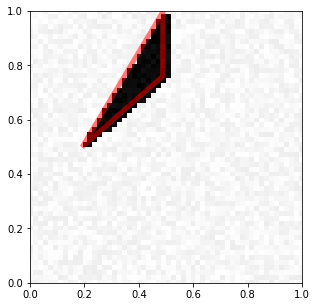

In [242]:
visu_pred(X_train[10], Y_train[10])

In [244]:
[X_vali, Y_vali] = m_dta_regr(250, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [245]:
regr = Sequential()

In [246]:
regr.add(Dense(units=128,kernel_initializer= 'uniform',activation="relu", input_shape=(5184,)))
regr.add(Dropout(0.3))
regr.add(Dense(units=64,kernel_initializer= 'uniform',activation="relu"))
regr.add(Dropout(0.3))
regr.add(Dense(units=6,kernel_initializer= 'uniform'))
regr.compile(optimizer="adam", loss='mse', metrics= ["mse"])
history=regr.fit(X_train,Y_train,validation_data=(X_vali,Y_vali),batch_size=32, epochs=300)

Train on 250 samples, validate on 250 samples
Epoch 1/300
250/250 [==============================] - 4s 17ms/step - loss: 0.1753 - mean_squared_error: 0.1753 - val_loss: 0.0998 - val_mean_squared_error: 0.0998
Epoch 2/300
250/250 [==============================] - 0s 1ms/step - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 3/300
250/250 [==============================] - 0s 1ms/step - loss: 0.1089 - mean_squared_error: 0.1089 - val_loss: 0.0943 - val_mean_squared_error: 0.0943
Epoch 4/300
250/250 [==============================] - 0s 1ms/step - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.0876 - val_mean_squared_error: 0.0876
Epoch 5/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0991 - mean_squared_error: 0.0991 - val_loss: 0.0845 - val_mean_squared_error: 0.0845
Epoch 6/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0986 - mean_squared_error: 0.0986 - val_loss: 0.0861 - val_me

Epoch 51/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0775 - val_mean_squared_error: 0.0775
Epoch 52/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - val_loss: 0.0801 - val_mean_squared_error: 0.0801
Epoch 53/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0784 - val_mean_squared_error: 0.0784
Epoch 54/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.0798 - val_mean_squared_error: 0.0798
Epoch 55/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - val_loss: 0.0829 - val_mean_squared_error: 0.0829
Epoch 56/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0746 - mean_squared_error: 0.0746 - val_loss: 0.0854 - val_mean_squared_error: 0.0854
Epoch 57/300
250

Epoch 101/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 0.0800 - val_mean_squared_error: 0.0800
Epoch 102/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0818 - val_mean_squared_error: 0.0818
Epoch 103/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - val_loss: 0.0772 - val_mean_squared_error: 0.0772
Epoch 104/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0760 - mean_squared_error: 0.0760 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 105/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0753 - mean_squared_error: 0.0753 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 106/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 107/

250/250 [==============================] - 0s 1ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0822 - val_mean_squared_error: 0.0822
Epoch 151/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.0810 - val_mean_squared_error: 0.0810
Epoch 152/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 153/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 154/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 155/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0720 - mean_squared_error: 0.0720 - val_loss: 0.0800 - val_mean_squared_error: 0.0800
Epoch 156/300
250/250 [=

Epoch 200/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0720 - mean_squared_error: 0.0720 - val_loss: 0.0791 - val_mean_squared_error: 0.0791
Epoch 201/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0822 - val_mean_squared_error: 0.0822
Epoch 202/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 203/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 204/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 205/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 206/

250/250 [==============================] - 0s 1ms/step - loss: 0.0712 - mean_squared_error: 0.0712 - val_loss: 0.0801 - val_mean_squared_error: 0.0801
Epoch 250/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 251/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0710 - mean_squared_error: 0.0710 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 252/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0807 - val_mean_squared_error: 0.0807
Epoch 253/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0720 - mean_squared_error: 0.0720 - val_loss: 0.0832 - val_mean_squared_error: 0.0832
Epoch 254/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0768 - val_mean_squared_error: 0.0768
Epoch 255/300
250/250 [=

Epoch 299/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0707 - mean_squared_error: 0.0707 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 300/300
250/250 [==============================] - 0s 1ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0800 - val_mean_squared_error: 0.0800


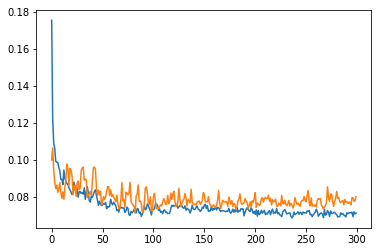

In [247]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [248]:
def m_test_regr():
    np.random.seed(50)
    [X_test, Y_test] = m_dta_regr(300, 20)
    return [X_test, Y_test]

In [249]:
[X_test, Y_test] = m_test_regr()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [250]:
Y_pred=regr.predict(X_test)

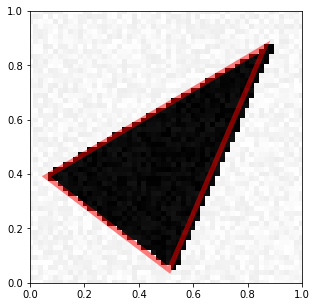

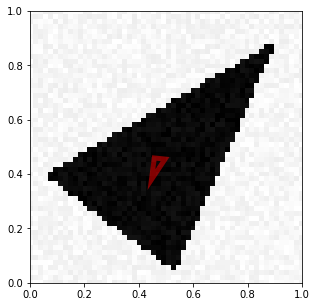

In [251]:
visu_pred(X_test[1], Y_test[1])
visu_pred(X_test[1], Y_pred[1])

In [252]:
X_Train = X_train.reshape([-1, 72,72,1])
X_Vali = X_vali.reshape([-1, 72,72,1])

In [253]:
from keras.layers import BatchNormalization

In [255]:
C_regr = Sequential()

C_regr.add(Conv2D(256,(3,3),input_shape=(72,72,1,),padding="same", activation='relu'))
C_regr.add(BatchNormalization())
C_regr.add(MaxPooling2D(pool_size=(2,2)))

C_regr.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
C_regr.add(BatchNormalization())
C_regr.add(MaxPooling2D(pool_size=(2,2)))

C_regr.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
C_regr.add(BatchNormalization())
C_regr.add(MaxPooling2D(pool_size=(2,2)))

C_regr.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
C_regr.add(BatchNormalization())
C_regr.add(MaxPooling2D(pool_size=(2,2)))


C_regr.add(Flatten())
C_regr.add(Dense(units=128, kernel_initializer="uniform", activation="relu"))
C_regr.add(BatchNormalization())
C_regr.add(Dense(units=6, kernel_initializer="uniform"))
C_regr.compile(loss='mse', optimizer='adam', metrics= ["mse"])
history=C_regr.fit(X_Train,Y_train,batch_size=32, validation_data=(X_Vali, Y_vali),epochs=20)

Train on 250 samples, validate on 250 samples
Epoch 1/20


KeyboardInterrupt: 

In [256]:
X_Test = X_test.reshape([-1, 72,72,1])

In [257]:
Y_pred=C_regr.predict(X_Test)

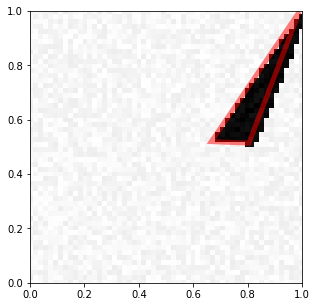

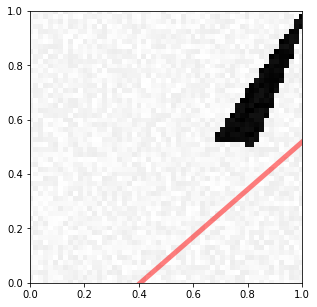

In [258]:
visu_pred(X_test[10], Y_test[10])
visu_pred(X_test[10], Y_pred[10])

## Denoise 

In [259]:
def m_drawing_denoise(figsize, U, V, noise=0.0):
    fg = plt.figure(figsize=(figsize, figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0, figsize)
    ax.set_ylim(0, figsize)
    ax.fill(U, V, "k")
    fg.canvas.draw()
    idta = np.frombuffer(fg.canvas.tostring_rgb(), dtype=np.uint8)[
        ::3].astype(np.float32)
    idtan = idta + noise * np.random.random(idta.size)
    plt.close(fg)
    return idtan, idta

In [260]:
def m_disk_denoise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize / 2, figsize / 2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize / 2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2 * np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return m_drawing_denoise(figsize, U, V, noise)

In [261]:
def m_triangle_denoise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random()) * figsize / 2
        middle = figsize / 2
        U = (middle, middle + size, middle - size)
        V = (middle + size, middle - size, middle - size)
    idtan, idta = m_drawing_denoise(figsize, U, V, noise)
    return [idtan,idta, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [262]:
def m_rectangle_denoise(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize / 2 + side / 2
        bottom = figsize / 2 - side / 2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return m_drawing_denoise(figsize, U, V, noise)

In [263]:
def m_dta_denoise(smpls, noise=0.0, free_location=False):
    i_size = m_rectangle_denoise()[0].shape[0]
    X = np.zeros([smpls, i_size])
    Y = np.zeros([smpls, i_size])
    print('Creating data:')
    for i in range(smpls):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = m_rectangle_denoise(noise, free_location)
        elif category == 1:
            X[i],Y[i] = m_disk_denoise(noise, free_location)
        else:
            [X[i],Y[i], V] = m_triangle_denoise(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y/255
    return [X, Y]

In [264]:
[X_train3,Y_train3]=m_dta_denoise(600,20,True)

Creating data:
0
100
200
300
400
500


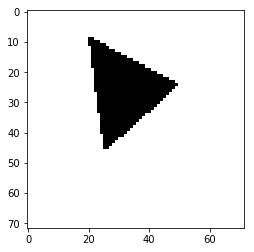

In [267]:
plt.imshow(Y_train3[200].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

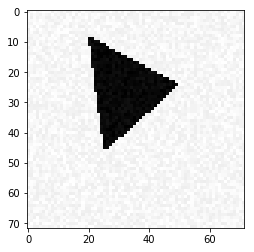

In [268]:
plt.imshow(X_train3[200].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [269]:
X_train3 = X_train3.reshape(X_train3.shape[0],72,72,1)
Y_train3 = Y_train3.reshape(Y_train3.shape[0],72,72,1)

In [270]:
from keras.layers import UpSampling2D

In [271]:
class5 = Sequential()
class5.add(Conv2D(32,(3, 3), activation='relu',padding = 'same' ,input_shape=(72,72,1)))
class5.add(MaxPooling2D(pool_size=(2, 2)))
class5.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same'))
class5.add(MaxPooling2D(pool_size=(2,2)))

class5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
class5.add(UpSampling2D(size=(2, 2)))
class5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
class5.add(UpSampling2D(size=(2, 2)))
class5.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding = 'same'))

In [272]:
class5.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [273]:
class5.fit(X_train3, Y_train3, epochs=75, batch_size=64)

Epoch 1/75
600/600 [==============================] - 20s 33ms/step - loss: 0.4163 - acc: 0.8273
Epoch 2/75
600/600 [==============================] - 18s 30ms/step - loss: 0.2005 - acc: 0.9122
Epoch 3/75
600/600 [==============================] - 18s 30ms/step - loss: 0.1515 - acc: 0.9563
Epoch 4/75
600/600 [==============================] - 18s 30ms/step - loss: 0.0934 - acc: 0.9728
Epoch 5/75
600/600 [==============================] - 18s 30ms/step - loss: 0.0447 - acc: 0.9851
Epoch 6/75
600/600 [==============================] - 18s 30ms/step - loss: 0.0476 - acc: 0.9835
Epoch 7/75
600/600 [==============================] - 19s 31ms/step - loss: 0.0425 - acc: 0.9838
Epoch 8/75
600/600 [==============================] - 18s 30ms/step - loss: 0.0310 - acc: 0.9885
Epoch 9/75
600/600 [==============================] - 19s 32ms/step - loss: 0.0404 - acc: 0.9845
Epoch 10/75
600/600 [==============================] - 18s 30ms/step - loss: 0.0288 - acc: 0.9889
Epoch 11/75
600/600 [========

In [274]:
Xmod = X_train3[10]

In [275]:
Xmod = Xmod.reshape(1,72,72,1)

In [276]:
pred=class5.predict(Xmod)

In [277]:
prediction_f=pred.reshape(72,72)

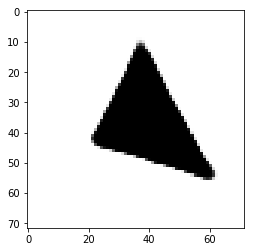

In [278]:
plt.imshow(prediction_f, cmap='gray')

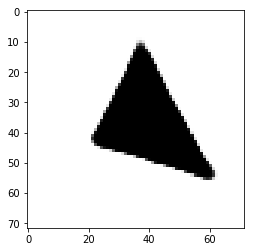

In [279]:
plt.imshow(prediction_f.reshape(72,72), cmap='gray')